# How to Build a Movie Recommender using Keras
> Our task is to predict the rating for a user/movie pair, with the idea that if we had a model that's good at this task then we could predict how a user would rate movies they haven't seen yet and recommend movies with the highest predicted rating.

- toc: true
- badges: false
- comments: true
- categories: [Keras, Movie]
- image:

## Introduction

Duration: 5

Our task is to predict the rating for a user/movie pair, with the idea that if we had a model that's good at this task then we could predict how a user would rate movies they haven't seen yet and recommend movies with the highest predicted rating.

### What you'll learn?

- Tensorflow Keras basics
- MovieLens Latest Small dataset exploration
- Neural net training and testing

### Why is this important?

- Tensorflow keras is a powerful library for building deep neural nets and we should have a good understanding of it to build advanced recommender systems
- Neural net based recommender models often gives superios performance over traditional models and this tutorial is a base to build your skill in this zone

### How it will work?

- We will use Colab, an online Ipython notebook, for this tutorial
- Download the movielens dataset
- Preprocess to make it ready to be consumed by the neural model
- Design simple neural net model architecture
- Train the model
- Design an advanced neural net model architecture on top of the basic one
- Again, train this advanced model
- Analyze and compare the models
- Build a simple inference function to get top-K recommendation for the given user

### Who is this for?

- People who are new in deep learning
- People looking to use tensorflow keras to build deep recommender models

### Important resources

- [Colab notebook](https://colab.research.google.com/gist/sparsh-ai/a60290ed48b0f2db6935a086cbf9a908/recohut-tutorial-stage-movielens-deep-learning-recommender-keras.ipynb)

<!-- ------------------------ -->

## Download and data

Duration: 2

We will directly feed the URL into pandas, to download the csv file as Pandas dataframe. 

This will download the `ratings` data:

```python
ratings = pd.read_csv('https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_LatestSmall_ratings.csv?raw=true')
ratings.head()
```

In the above code snippet, first line will download the data and second line is to print the top N rows (default is 5, but we can mention any number inside those brackets). This is how the top-5 rows looks for the `ratings` data:



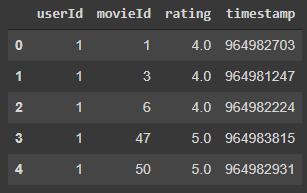

and this will download the movies data:

```python
movies = pd.read_csv('https://github.com/sparsh-ai/reco-data/blob/master/MovieLens_LatestSmall_movies.csv?raw=true')
movies.head()
```



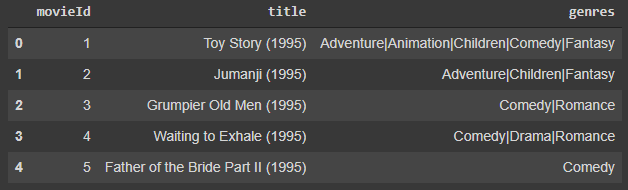

## Preprocessing

Duration: 5

### Pivot table

To get a better sense of what the data looks like, we can turn it into a table by selecting the top 15 users/movies from the data and joining them together. The result shows how each of the top users rated each of the top movies.

```python
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)
```

In this snippet, we are using pandas `groupby` method to identify and grab the top-15 users and items from the ratings dataframe, and then using `crosstab` method to create the pivot table. 

This is how the table looks. In this table e.g., user 68 gave a rating of 2.5 to movie 1, and user 288 hasn't yet gave any rating to movie 50. And we are assuming that this user hasn't seen this movie. Our objective is to estimate this rating value.

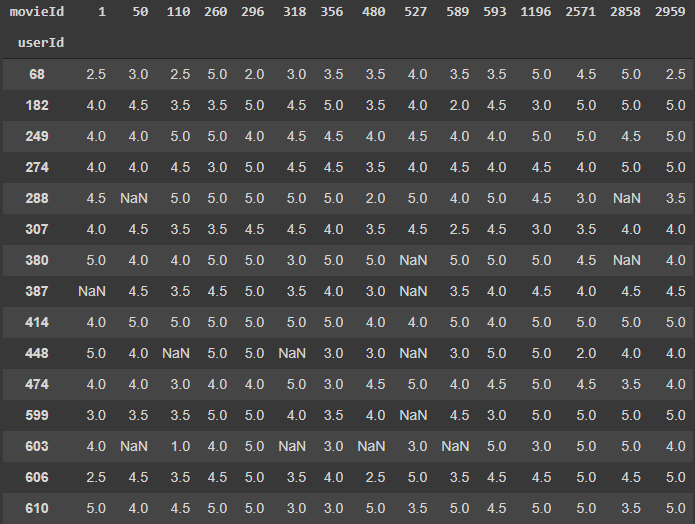

### Encoding

To build our first collaborative filtering model, we need to take care of a few things first. The user/movie fields are currently non-sequential integers representing some unique ID for that entity. We need them to be sequential starting at zero to use for modeling (you'll see why later). We can use scikit-learn's LabelEncoder class to transform the fields. We'll also create variables with the total number of unique users and movies in the data, as well as the min and max ratings present in the data, for reasons that will become apparent shortly.

```python
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating
```

### Train/test split

```python
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
```

We are using sklearn's `train_test_split` method to split the dataset into train and test set. *test_size=0.1* means 90% of the data is in train set and remaining 10% in test set. In last line of the above snippet, we are printing the shaped of datasets, which looks like this:

`((90752, 2), (10084, 2), (90752,), (10084,))`

Another constant we'll need for the model is the number of factors per user/movie. This number can be whatever we want, however for the collaborative filtering model it does need to be the same size for both users and movies. The famous prof. Jeremy Howard said he played around with different numbers and 50 seemed to work best so we'll go with that.

Finally, we need to turn users and movies into separate arrays in the training and test data. This is because in Keras they'll each be defined as distinct inputs, and the way Keras works is each input needs to be fed in as its own array.

```python
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
```

<!-- ------------------------ -->

## Model version 1

Duration: 5

Now we get to the model itself. The main idea here is we're going to use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) that start out as random numbers but are fit by the model to capture the essential qualities of each user/movie. We can accomplish this by computing the dot product between a user vector and a movie vector to get a predicted rating. The code is fairly simple, there isn't even a traditional neural network layer or activation involved. I stuck some regularization on the embedding layers and used a different initializer but even that probably isn't necessary. Notice that this is where we need the number of unique users and movies, since those are required to define the size of each embedding matrix.

```python
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model
```

This is kind of a neat example of how flexible and powerful modern computation frameworks like Keras and PyTorch are. Even though these are billed as deep learning libraries, they have the building blocks to quickly create any computation graph you want and get automatic differentiation essentially for free. Below you can see that all of the parameters are in the embedding layers, we don't have any traditional neural net components at all.

The model architecture would look like this:



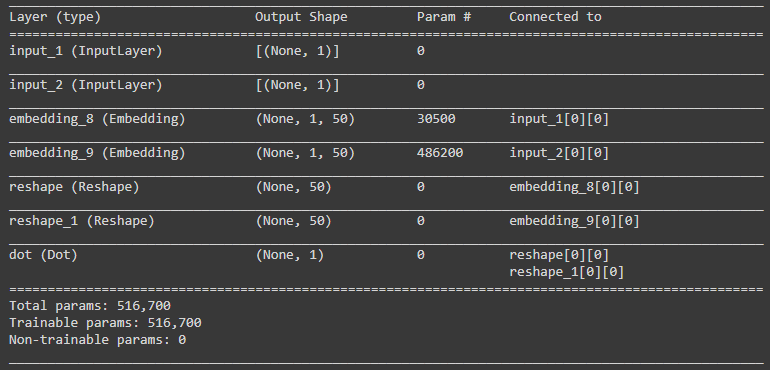

Let's go ahead and train this for a few epochs and see what we get.

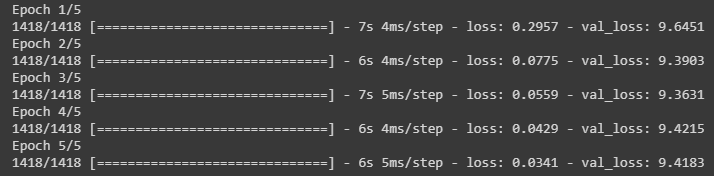

The training loss is low but validation loss is comparatively very high and not decreasing. This clearly indicates that the model is overfitting because it just memorized all the patterns in training set and when we ask to predict unseen ratings, which are in validation set, model didn't performed at all.

<!-- ------------------------ -->

## Model version 2

Duration: 5

The model we trained in previous step is not bad for a first try. We can make some improvements though. The first thing we can do is add a "bias" to each embedding. The concept is similar to the bias in a fully-connected layer or the intercept in a linear model. It just provides an extra degree of freedom. We can implement this idea using new embedding layers with a vector length of one. The bias embeddings get added to the result of the dot product.

The second improvement we can make is running the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. This is a neat technique that introduces a non-linearity into the output and results in a modest performance bump.

I also refactored the code a bit by pulling out the embedding layer and reshape operation into a separate class.

```python
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
```

The improved model design code is as follows:

```python
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model
```

The model summary shows the new graph. Notice the additional embedding layers with parameter numbers equal to the unique user and movie counts.



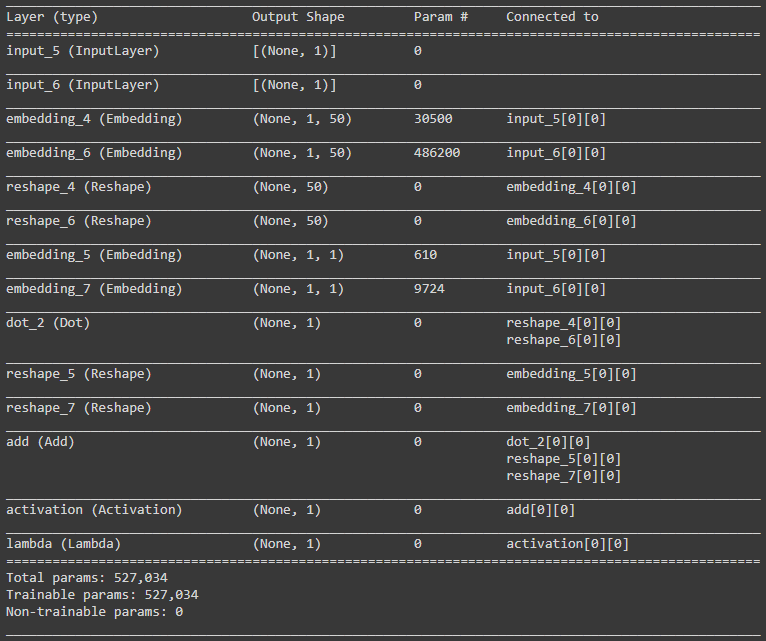

Let's train this one for a few epochs and see how it performs:

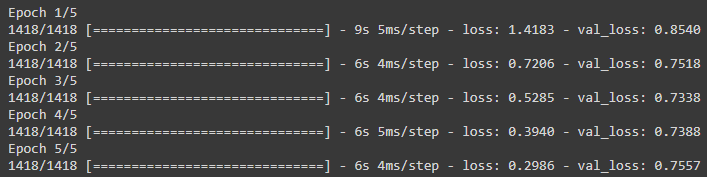

Unlike the previous model, here we can see that both train and validation loss is decreasing and the difference is not huge. Those two additions to the model resulted in a pretty sizable improvement. Validation error is now down to ~0.76 which is about as good as what Jeremy got (and I believe close to SOTA for this data set).

That pretty much covers the conventional approach to solving this problem, but there's another way we can tackle this. Let's see in next step.

<!-- ------------------------ -->

## Model version 3

Duration: 5

Instead of taking the dot product of the embedding vectors, what if we just concatenated the embeddings together and stuck a fully-connected layer on top of them? It's still not technically "deep" but it would at least be a neural network! To modify the code, we can remove the bias embeddings from V2 and do a concat on the embedding layers instead. Then we can add some dropout, insert a dense layer, and stick some dropout on the dense layer as well. Finally, we'll run it through a single-unit dense layer to keep the sigmoid trick at the end.

```python
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model
```

The architecture would look like this:

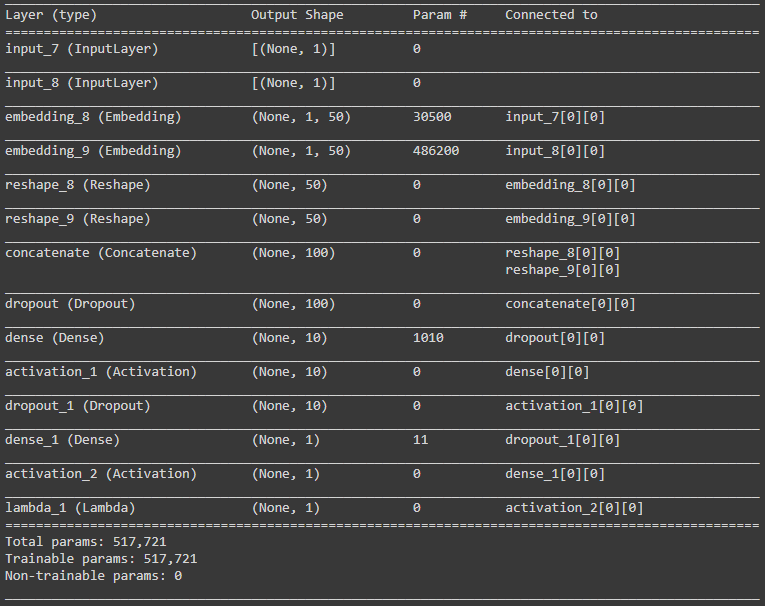

Training for a few epochs gives us pretty good results:

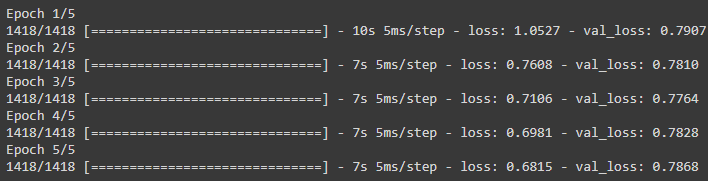

Without doing any tuning at all we still managed to get a result that's pretty close to the best performance we saw with the traditional approach. This technique has the added benefit that we can easily incorporate additional features into the model. For instance, we could create some date features from the timestamp or throw in the movie genres as a new embedding layer. We could tune the size of the movie and user embeddings independently since they no longer need to match. Lots of possibilities here.

<!-- ------------------------ -->

## Model version 4

Duration: 2

Let's build a more advanced version of the model by adding bias and regularization techniques.

```python
class RecommenderNetV2(Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNetV2, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)
```

To compile and train the model, we will use the following settings:

```python
model = RecommenderNetV2(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.001)
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)
```

Training for a few epochs already gives us impressive results:

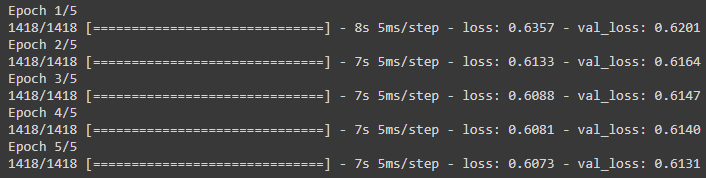

The loss curve plot would look like this:

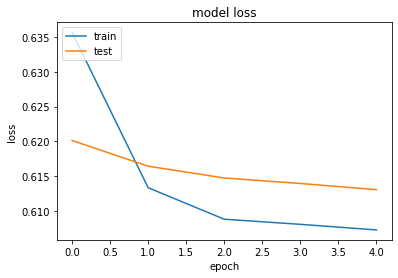

## Inference

Duration: 2

In this step, we will build a simple method to recommend top-10 movies for the given user id. We will be using the model version 4 that we trained in last step. To test it out, let's take an example of a random user. First, print out the top movies rated by that user and then print out the top-10 predicted movies for that user. 

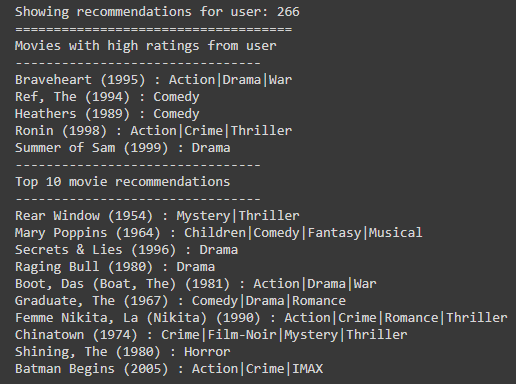

## Conclusion

Duration: 2

Congratulations!

### What we've covered

- Loaded and preprocessed movielens dataset
- Trained and compared 4 versions of neural net models using tensorflow keras

### Next steps

- Train for more epochs to see if performance improves
- Add more enhancements to the model

### Links and References

- [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
- [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)